# Tabulation API Example: Presumed PDF SLFM Tables

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Building presumed PDF adiabatic and nonadiabatic SFLM libraries for turbulent flows

- Using Spitfire's wrapper around the Python interface of [`TabProps`](https://multiscale.utah.edu/software/) to easily extend tables with clipped Gaussian and Beta PDFs

In this demo, we build reaction models and then incorporate the presumed PDF mixing models outlined in the mixing model documentation.



## The Reaction Models
First we'll build the reaction models for an n-heptane/air system following prior demonstrations.

In [1]:
from spitfire import (ChemicalMechanismSpec, 
                      Library,
                      FlameletSpec, 
                      build_adiabatic_slfm_library,
                      build_nonadiabatic_defect_transient_slfm_library)
import matplotlib.pyplot as plt
import numpy as np

mech = ChemicalMechanismSpec(cantera_xml='heptane-liu-hewson-chen-pitsch-highT.xml', 
                             group_name='gas')

pressure = 101325.

air = mech.stream(stp_air=True)
fuel = mech.stream('TPY', (372., pressure, 'NXC7H16:1'))

flamelet_specs = FlameletSpec(mech_spec=mech, 
                              initial_condition='equilibrium',
                              oxy_stream=air,
                              fuel_stream=fuel,
                              grid_points=34)

l_ad = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=np.logspace(-1, 2, 8),
                                    diss_rate_ref='stoichiometric',
                                    verbose=False)

l_na = build_nonadiabatic_defect_transient_slfm_library(flamelet_specs,
                                                        diss_rate_values=np.logspace(-1, 2, 8),
                                                        diss_rate_ref='stoichiometric',
                                                        n_defect_st=16,
                                                        integration_args={'transient_tolerance': 1.e-12})
# note here: the transient_tolerance is specified to avoid seeing "failure" messages,
# but in absence of this flag, Spitfire will automatically iterate after failures to obtain a solution

Deprecation warning: the "cantera_xml" input argument to ChemicalMechanismSpec is deprecated and will be removed.
Use the "cantera_input" argument instead.
----------------------------------------------------------------------------------
building nonadiabatic (defect) SLFM library
----------------------------------------------------------------------------------
- mechanism: heptane-liu-hewson-chen-pitsch-highT.xml
- 38 species, 105 reactions
- stoichiometric mixture fraction: 0.062
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: heptane-liu-hewson-chen-pitsch-highT.xml
- 38 species, 105 reactions
- stoichiometric mixture fraction: 0.062
----------------------------------------------------------------------------------
   1/   8 (chi_stoich = 

## Tabulated Properties

Running a CFD calculation requires fluid properties such as the viscosity, heat capacity, and enthalpy. These are computed on the laminar reaction model and are then integrated with the presumed PDF. So before applying the presumed PDF mixing model we make new libraries with just a few properties likely necessary for the simulation. 
We typically don't need to tabulate the entire set of mass fractions, so we'll remove them to save time.

In [2]:
from spitfire import get_ct_solution_array
import copy

def tabulate_properties(TY_lib):
    ct_sol, lib_shape = get_ct_solution_array(mech, TY_lib)
    prop_lib = copy.copy(TY_lib)
    prop_lib.remove(*prop_lib.props)
    
    prop_lib['temperature'] = ct_sol.T.reshape(lib_shape)
    prop_lib['viscosity'] = ct_sol.viscosity.reshape(lib_shape)
    prop_lib['enthalpy'] = ct_sol.enthalpy_mass.reshape(lib_shape)
    prop_lib['heat_capacity_cp'] = ct_sol.cp_mass.reshape(lib_shape)

    return prop_lib


prop_ad = tabulate_properties(l_ad)
prop_na = tabulate_properties(l_na)

## Presumed PDFs

First, we'll use TabProps to evaluate the clipped Gaussian and $\beta$ PDFs for some representative means and variances. Note the major differences between the PDF types at higher variances and near the boundaries. The poor behavior of the $\beta$ PDF in these regimes makes it substantially harder to integrate than the clipped Gaussian.

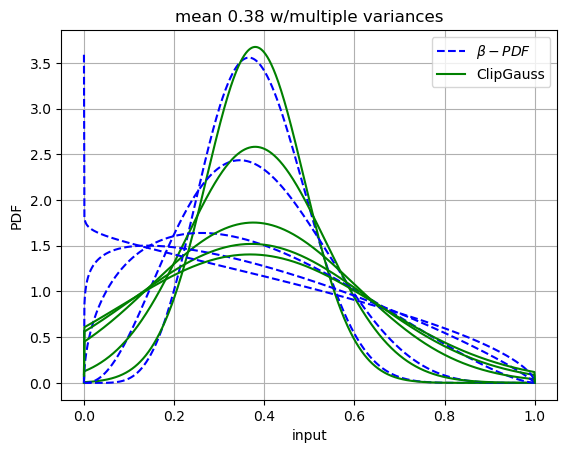

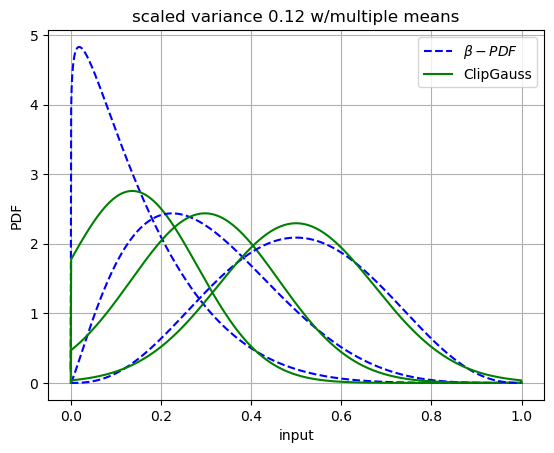

In [3]:
from spitfire import BetaPDF, ClipGaussPDF

ztest = np.linspace(0, 1, 1000)

cg = ClipGaussPDF()
bp = BetaPDF()

zmean = 0.38
for i, zsvar in enumerate([0.05, 0.1, 0.2, 0.25, 0.28]):
    bp.set_mean(zmean)
    bp.set_scaled_variance(zsvar)
    plt.plot(ztest, bp.get_pdf(ztest), 'b--', label='$\\beta-PDF$' if i == 0 else None)
    cg.set_mean(zmean)
    cg.set_scaled_variance(zsvar)
    plt.plot(ztest, cg.get_pdf(ztest), 'g-', label='ClipGauss' if i == 0 else None)
plt.title(f'mean {zmean:.2f} w/multiple variances')
plt.xlabel('input')
plt.ylabel('PDF')
plt.grid()
plt.legend()
plt.show()

zsvar = 0.12
for i, zmean in enumerate([0.15, 0.3, 0.5]):
    bp.set_mean(zmean)
    bp.set_scaled_variance(zsvar)
    plt.plot(ztest, bp.get_pdf(ztest), 'b--', label='$\\beta-PDF$' if i == 0 else None)
    cg.set_mean(zmean)
    cg.set_scaled_variance(zsvar)
    plt.plot(ztest, cg.get_pdf(ztest), 'g-', label='ClipGauss' if i == 0 else None)
plt.title(f'scaled variance {zsvar:.2f} w/multiple means')
plt.xlabel('input')
plt.ylabel('PDF')
plt.grid()
plt.legend()
plt.show()

Another PDF supported in Spitfire is a `DoubleDeltaPDF` shown below. To be precise, what we show below is not the actual double delta PDF but its integral.

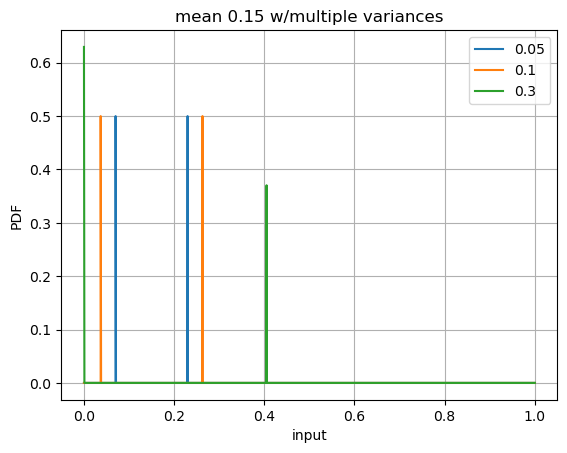

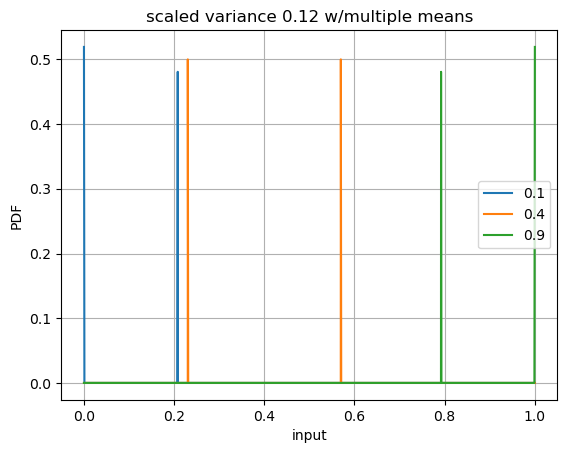

In [4]:
from spitfire import DoubleDeltaPDF

ztest = np.linspace(0, 1, 1000)
colors = ['k','r','b']

ddelta = DoubleDeltaPDF()

zmean = 0.15
for i, zsvar in enumerate([0.05, 0.1, 0.3]):
    ddelta.set_mean(zmean)
    ddelta.set_scaled_variance(zsvar)
    nonzero_points = np.array([ddelta.find_bounds()[0],ddelta.find_bounds()[1]])
    zfull = np.sort(np.hstack((ztest, nonzero_points)))
    plt.plot(zfull, ddelta.get_pdf(zfull), '-', label=str(zsvar))
plt.title(f'mean {zmean:.2f} w/multiple variances')
plt.xlabel('input')
plt.ylabel('PDF')
plt.grid()
plt.legend()
plt.show()

zsvar = 0.12
for i, zmean in enumerate([0.1, 0.4, 0.9]):
    ddelta.set_mean(zmean)
    ddelta.set_scaled_variance(zsvar)
    nonzero_points = np.array([ddelta.find_bounds()[0],ddelta.find_bounds()[1]])
    zfull = np.sort(np.hstack((ztest, nonzero_points)))
    plt.plot(zfull, ddelta.get_pdf(zfull), '-', label=str(zmean))
plt.title(f'scaled variance {zsvar:.2f} w/multiple means')
plt.xlabel('input')
plt.ylabel('PDF')
plt.grid()
plt.legend()
plt.show()


## Incorporating the Mixing Model: PDFs supported by Spitfire

Spitfire provides the `apply_mixing_model` which takes an existing `Library`, for instance those computed above, and incorporates subgrid variation for all dimensions and adds the (default) suffix `_mean`.

Spitfire provides optimized PDF integrators for the following PDFs:

- clipped Gaussian (`'ClipGauss'`)

- $\beta$ PDF (`'Beta'`)

- double delta PDF (`'DoubleDelta'`)

Tabprops handles integration of the clipped Gaussian while `scipy.integrate.quad` handles integration of the Beta PDF. The DoubleDelta PDF allows for analytic solutions. In addition to these supported PDFs, Spitfire allows you to "roll your own" PDF integrator, a feature to be shown in following demonstrations.


When calling ``apply_mixing_model`` on particularly large laminar
libraries, speedup through parallelism can be achieved when ``num_procs`` is greater than 1 by setting ``parallel_type`` to one of the following options:

- `'property'`: parallelize over properties

- `'property-mean'`: parallelize over mean and properties

- `'property-variance'`: parallelize over variance and properties

- `'full'`: parallelize over mean, variance, and properties

- `'default'`: use the fastest parallel method on average depending on the pdf


In [5]:
from spitfire import apply_mixing_model, PDFSpec

scaled_variance_values = np.array([0, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])

mixing_spec = {'mixture_fraction': PDFSpec(pdf='ClipGauss', scaled_variance_values=scaled_variance_values)}

t_cg_prop_ad = apply_mixing_model(prop_ad, mixing_spec, verbose=True)
t_cg_prop_na = apply_mixing_model(prop_na, mixing_spec, verbose=True)

scaled_scalar_variance_mean: computing 10880 integrals... completed in 2.9 seconds, average = 3756 integrals/s.
scaled_scalar_variance_mean: computing 174080 integrals... completed in 42.5 seconds, average = 4092 integrals/s.


Now take a quick look at the tables. Input dimensions have been suffixed with `_mean` and the scalar variance (its scaled form that varies between 0 and 1) is incorporated as the final dimension. Futher, the `extra_attributes` dictionary that holds library metadata saves the `mixing_spec` dictionary for later reference.

In [6]:
print(t_cg_prop_ad)
print(t_cg_prop_na)


Spitfire Library with 3 dimensions and 4 properties
------------------------------------------
1. Dimension "mixture_fraction_mean" spanning [0.0, 1.0] with 34 points
2. Dimension "dissipation_rate_stoich_mean" spanning [0.1, 100.0] with 8 points
3. Dimension "scaled_scalar_variance_mean" spanning [0.0, 1.0] with 10 points
------------------------------------------
temperature         , min = 300.0 max = 2122.096955226145
viscosity           , min = 1.2370131775920866e-05 max = 6.906467776682902e-05
enthalpy            , min = -1739935.6849118916 max = 1901.8191601112542
heat_capacity_cp    , min = 1011.3329912202539 max = 2422.2079033535088
Extra attributes: {'mech_spec': <spitfire.chemistry.mechanism.ChemicalMechanismSpec object at 0x7f13641a4dd0>, 'mixing_spec': {'mixture_fraction': <spitfire.chemistry.tabulation.PDFSpec object at 0x7f1389e6bbd0>, 'dissipation_rate_stoich': <spitfire.chemistry.tabulation.PDFSpec object at 0x7f1389e6b290>}}
------------------------------------------

In [7]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import Normalize

To finish things off we can show some simple visualiations of the data.

/ascldap/users/earmstr/.conda/envs/newsp/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


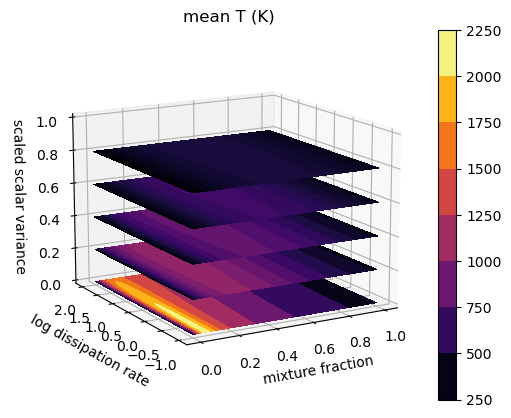

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
z = np.squeeze(t_cg_prop_ad.mixture_fraction_mean_grid[:, :, 0])
x = np.squeeze(np.log10(t_cg_prop_ad.dissipation_rate_stoich_mean_grid[:, :, 0]))
v_list = t_cg_prop_ad.scaled_scalar_variance_mean_values
for idx in [7, 6, 5, 4, 0]:
    p = ax.contourf(z, x, np.squeeze(t_cg_prop_ad['temperature'][:, :, idx]), 
                    offset=v_list[idx], 
                    cmap='inferno',
                    norm=Normalize(300, 2200))
plt.colorbar(p)
ax.view_init(elev=14, azim=-120)
ax.set_zlim([0, 1])
ax.set_xlabel('mixture fraction')
ax.set_ylabel('log dissipation rate')
ax.set_zlabel('scaled scalar variance')
ax.set_title('mean T (K)')
plt.show()

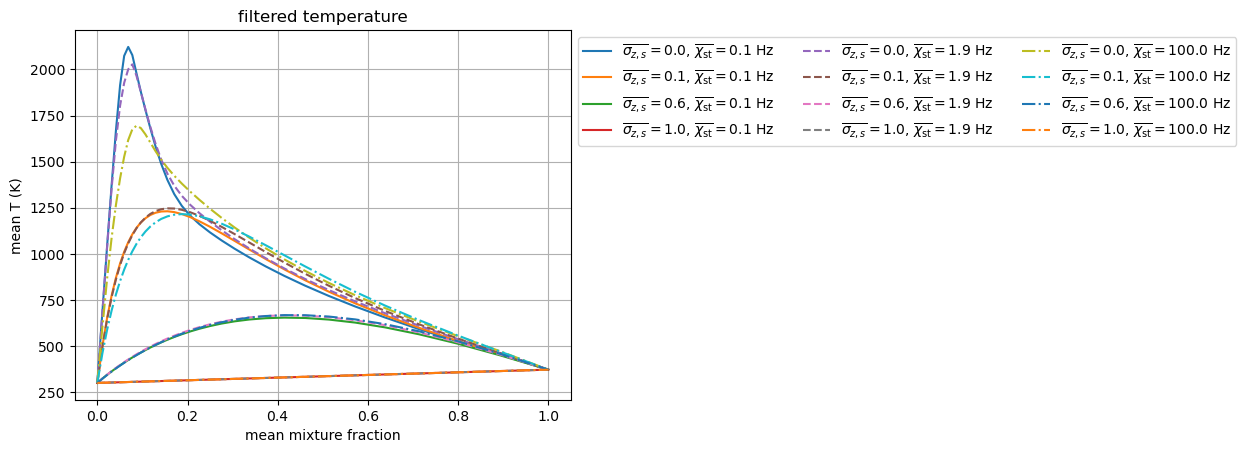

In [9]:
j = 0
chi = t_cg_prop_ad.dissipation_rate_stoich_mean_values[j]
for i in range(0, t_cg_prop_ad.scaled_scalar_variance_mean_npts, 3):
    svar = t_cg_prop_ad.scaled_scalar_variance_mean_values[i]
    plt.plot(t_cg_prop_ad.mixture_fraction_mean_values, np.squeeze(t_cg_prop_ad['temperature'][:, j, i]),
             '-',
             label='$\\overline{\sigma_{z,s}}=$'+f'{svar}'+', $\\overline{\\chi_{\\rm st}}=$'+f'{chi:.1f} Hz')
j = 3
chi = t_cg_prop_ad.dissipation_rate_stoich_mean_values[j]
for i in range(0, t_cg_prop_ad.scaled_scalar_variance_mean_npts, 3):
    svar = t_cg_prop_ad.scaled_scalar_variance_mean_values[i]
    plt.plot(t_cg_prop_ad.mixture_fraction_mean_values, np.squeeze(t_cg_prop_ad['temperature'][:, j, i]),
             '--',
             label='$\\overline{\sigma_{z,s}}=$'+f'{svar}'+', $\\overline{\\chi_{\\rm st}}=$'+f'{chi:.1f} Hz')
j = 7
chi = t_cg_prop_ad.dissipation_rate_stoich_mean_values[j]
for i in range(0, t_cg_prop_ad.scaled_scalar_variance_mean_npts, 3):
    svar = t_cg_prop_ad.scaled_scalar_variance_mean_values[i]
    plt.plot(t_cg_prop_ad.mixture_fraction_mean_values, np.squeeze(t_cg_prop_ad['temperature'][:, j, i]),
             '-.',
             label='$\\overline{\sigma_{z,s}}=$'+f'{svar}'+', $\\overline{\\chi_{\\rm st}}=$'+f'{chi:.1f} Hz')
plt.xlabel('mean mixture fraction')
plt.ylabel('mean T (K)')
plt.title('filtered temperature')
plt.grid()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=3)
plt.show()

Below, we compare the convolution of a property using the different supported PDFs. We will pick a single property profile.

In [7]:
prop = 'temperature'
sampled_lib = Library(prop_ad.dims[0])
sampled_lib[prop] = Library.copy(prop_ad)[prop][:,-1]

t_cg_T_ad = apply_mixing_model(sampled_lib, {'mixture_fraction': PDFSpec(pdf='ClipGauss', scaled_variance_values=scaled_variance_values)}, verbose=True)
t_bp_T_ad = apply_mixing_model(sampled_lib, {'mixture_fraction': PDFSpec(pdf='Beta', scaled_variance_values=scaled_variance_values)}, verbose=True)
t_dd_T_ad = apply_mixing_model(sampled_lib, {'mixture_fraction': PDFSpec(pdf='DoubleDelta', scaled_variance_values=scaled_variance_values)}, verbose=True)


scaled_scalar_variance_mean: computing 340 integrals... completed in 0.2 seconds, average = 1962 integrals/s.
scaled_scalar_variance_mean: computing 340 integrals... completed in 4.1 seconds, average = 83 integrals/s.
scaled_scalar_variance_mean: computing 340 integrals... completed in 0.0 seconds, average = 29148 integrals/s.


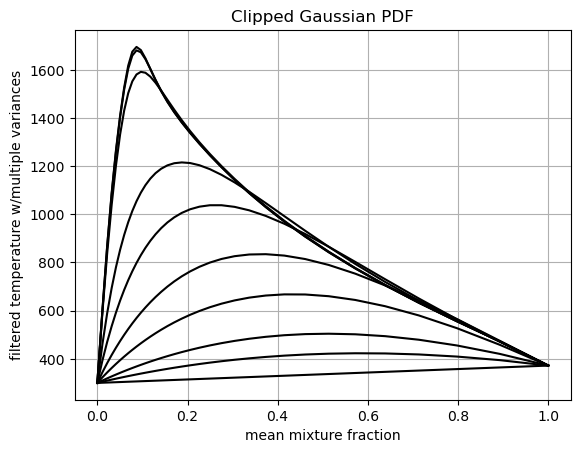

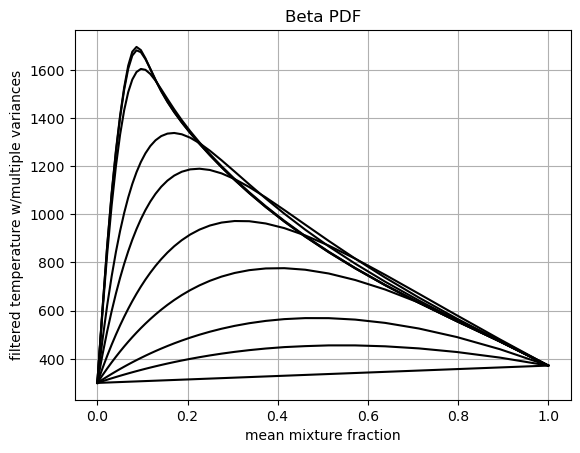

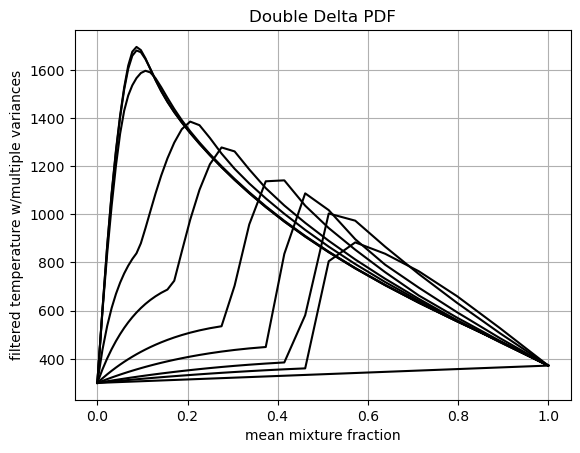

In [8]:
for i in range(scaled_variance_values.size):
    plt.plot(t_cg_T_ad.mixture_fraction_mean_values, t_cg_T_ad[prop][:, i], 'k-')
plt.xlabel('mean mixture fraction')
plt.ylabel('filtered '+prop+' w/multiple variances')
plt.title('Clipped Gaussian PDF')
plt.grid()
plt.show()

for i in range(scaled_variance_values.size):
    plt.plot(t_bp_T_ad.mixture_fraction_mean_values, t_bp_T_ad[prop][:, i], 'k-')
plt.xlabel('mean mixture fraction')
plt.ylabel('filtered '+prop+' w/multiple variances')
plt.title('Beta PDF')
plt.grid()
plt.show()

for i in range(scaled_variance_values.size):
    plt.plot(t_dd_T_ad.mixture_fraction_mean_values, t_dd_T_ad[prop][:, i], 'k-')
plt.xlabel('mean mixture fraction')
plt.ylabel('filtered '+prop+' w/multiple variances')
plt.title('Double Delta PDF')
plt.grid()
plt.show()


All PDFs, $P(\phi)$, must satisfy the following integrals:

1. $1 = \int_{-\infty}^\infty P(\phi) \mathrm{d}\phi$

2. $\bar{\phi} = \int_{-\infty}^\infty \phi P(\phi) \mathrm{d}\phi$

3. $\sigma_{\phi}^2 = \int_{-\infty}^\infty (\phi - \bar{\phi})^2 P(\phi) \mathrm{d}\phi$

Spitfire provides the function `compute_pdf_max_integration_errors` for computing the relative errors in satisfying those integrals. This is useful when determining acceptable parameters for the $\beta$-PDF, for example. Below we show the relative errors using the default values for the `BetaPDF` parameters.

In [9]:
from spitfire import compute_pdf_max_integration_errors

svars = np.array([0., 1.e-5, 6.e-4, 1.e-3, 0.1, 0.5, 0.8, 0.86, 0.9, 0.95, 1.])
means = np.hstack((0,np.logspace(-5,0,100)))

pdf = BetaPDF(scaled_variance_max_integrate=0.86, 
              scaled_variance_min_integrate=6.e-4, 
              mean_boundary_integrate=6.e-5)

print(compute_pdf_max_integration_errors(pdf, means, svars))


(0.0005913180615271241, 2.4555011311778803e-06, 0.009900892069395257)
